Importings:

In [1]:
# Importing packages
import numpy as np  
import os  
import matplotlib.pyplot as plt  
from PIL import Image  
import torch  
import torch.nn as nn
import torch.optim as optim   
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset 
%matplotlib inline

In [2]:
""" Dataset used to import and export data """
class DenoisingDB(Dataset):

    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()

        self.input_imgs_path = input_imgs_path
        self.cleaned_imgs_path = cleaned_imgs_path
        self.input_images = sorted(os.listdir(input_imgs_path))
        self.cleaned_images = sorted(os.listdir(cleaned_imgs_path))
        

    def __len__(self):
        length = len(self.input_images)
        return length

    def __getitem__(self, idx):
        input_img_path = os.path.join(self.input_imgs_path, self.input_images[idx]) # single image path
        cleaned_img_path = os.path.join(self.cleaned_imgs_path, self.cleaned_images[idx])

        input_img = Image.open(input_img_path).convert("RGB")
        cleaned_img = Image.open(cleaned_img_path).convert("RGB")

        # crop the image
        input_img = input_img.crop((0,0,128,128))
        cleaned_img = cleaned_img.crop((0,0,128,128))
      

        # convert image to pytorch tensor
        input_img = torch.from_numpy(np.array(input_img)).permute(2,0,1).float() / 255.0
        cleaned_img = torch.from_numpy(np.array(cleaned_img)).permute(2,0,1).float() / 255.0


        return (input_img, cleaned_img)


In [3]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # (64, 128, 128)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 128, 128)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # (256, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (256, 64, 64)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # (256, 64, 64)
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # (128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (128, 32, 32)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),  #(128, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # (64, 128, 128)
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),   # (3, 128, 128)
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)

        return x

In [4]:
# Create an instance of the network
model = DenoisingCNN()

In [5]:
def loss_function(prediction, target):
    """
    Calculate the Mean Squared Error (MSE) loss between the prediction and the target.

    Arguments:
    prediction : torch.Tensor
        The predicted image.
    target : torch.Tensor
        The target image for reconstruction.

    Returns:
    loss : torch.Tensor
        The computed loss.
    """

    # MSE loss
    loss = torch.mean((prediction - target) ** 2)

    return loss


In [6]:
dataset_path = "./data/"

input_imgs_path = os.path.join(dataset_path,"input_noisy_images/")
cleaned_imgs_path = os.path.join(dataset_path,"target_clean_images/")

Training part:

In [7]:
# config
num_epochs = 100
batch_size = 16
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # try to use cuda acceleration

# load data
dataset = DenoisingDB(input_imgs_path, cleaned_imgs_path)

# split dataset into training and testing
train_size = int(0.8 * len(dataset))  # 80% training
test_size = len(dataset) - train_size  # 20% test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimiser = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimiser


# set model to training mode
model.train()
model = model.to(device)


#Training
print(f"------Training Started------")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for (batch_idx, (input_img, cleaned_img)) in enumerate(train_loader):
        input_img, cleaned_img = input_img.to(device), cleaned_img.to(device)
        optimiser.zero_grad()
        output = model(input_img)
        loss = loss_function(output, cleaned_img)
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_epoch_loss:.4f}")

    # evaluate model every 10 epoch
    if (epoch+1) %10 == 0:
        model.eval()  
        test_loss = 0.0
        with torch.no_grad():  
            for input_img, cleaned_img in test_loader:
                input_img, cleaned_img = input_img.to(device), cleaned_img.to(device)
                output = model(input_img)
                loss = loss_function(output, cleaned_img)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")
        model.train()  # set back to training mode
print(f"------Training Completed------")

------Training Started------
Epoch 1/100, Training Loss: 0.1977
Epoch 2/100, Training Loss: 0.1922
Epoch 3/100, Training Loss: 0.1654
Epoch 4/100, Training Loss: 0.0790
Epoch 5/100, Training Loss: 0.0654
Epoch 6/100, Training Loss: 0.0674
Epoch 7/100, Training Loss: 0.0674
Epoch 8/100, Training Loss: 0.0675
Epoch 9/100, Training Loss: 0.0665
Epoch 10/100, Training Loss: 0.0661
Epoch 10/100, Test Loss: 0.0707
Epoch 11/100, Training Loss: 0.0591
Epoch 12/100, Training Loss: 0.0564
Epoch 13/100, Training Loss: 0.0556
Epoch 14/100, Training Loss: 0.0549
Epoch 15/100, Training Loss: 0.0551
Epoch 16/100, Training Loss: 0.0532
Epoch 17/100, Training Loss: 0.0518
Epoch 18/100, Training Loss: 0.0497
Epoch 19/100, Training Loss: 0.0465
Epoch 20/100, Training Loss: 0.0434
Epoch 20/100, Test Loss: 0.0484
Epoch 21/100, Training Loss: 0.0417
Epoch 22/100, Training Loss: 0.0407
Epoch 23/100, Training Loss: 0.0384
Epoch 24/100, Training Loss: 0.0368
Epoch 25/100, Training Loss: 0.0337
Epoch 26/100, Tr

In [10]:
'''SAVE model.  Be careful before executing this block'''
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"denoiser":model}, "models/denoiser.pth")

In [11]:
'''LOAD model'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # try to use cuda acceleration
state_dict = torch.load("models/denoiser.pth")
denoiser = state_dict["denoiser"].to(device)

C:\Users\yaaly\AppData\Local\Temp\ipykernel_7024\445804747.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("models/denoiser.pth")


Demo:

In [8]:
def plot_images_with_text(images, titles, texts=None):
    N_cols = len(images)
    N_rows = len(images[0])

    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))

    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])

    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()



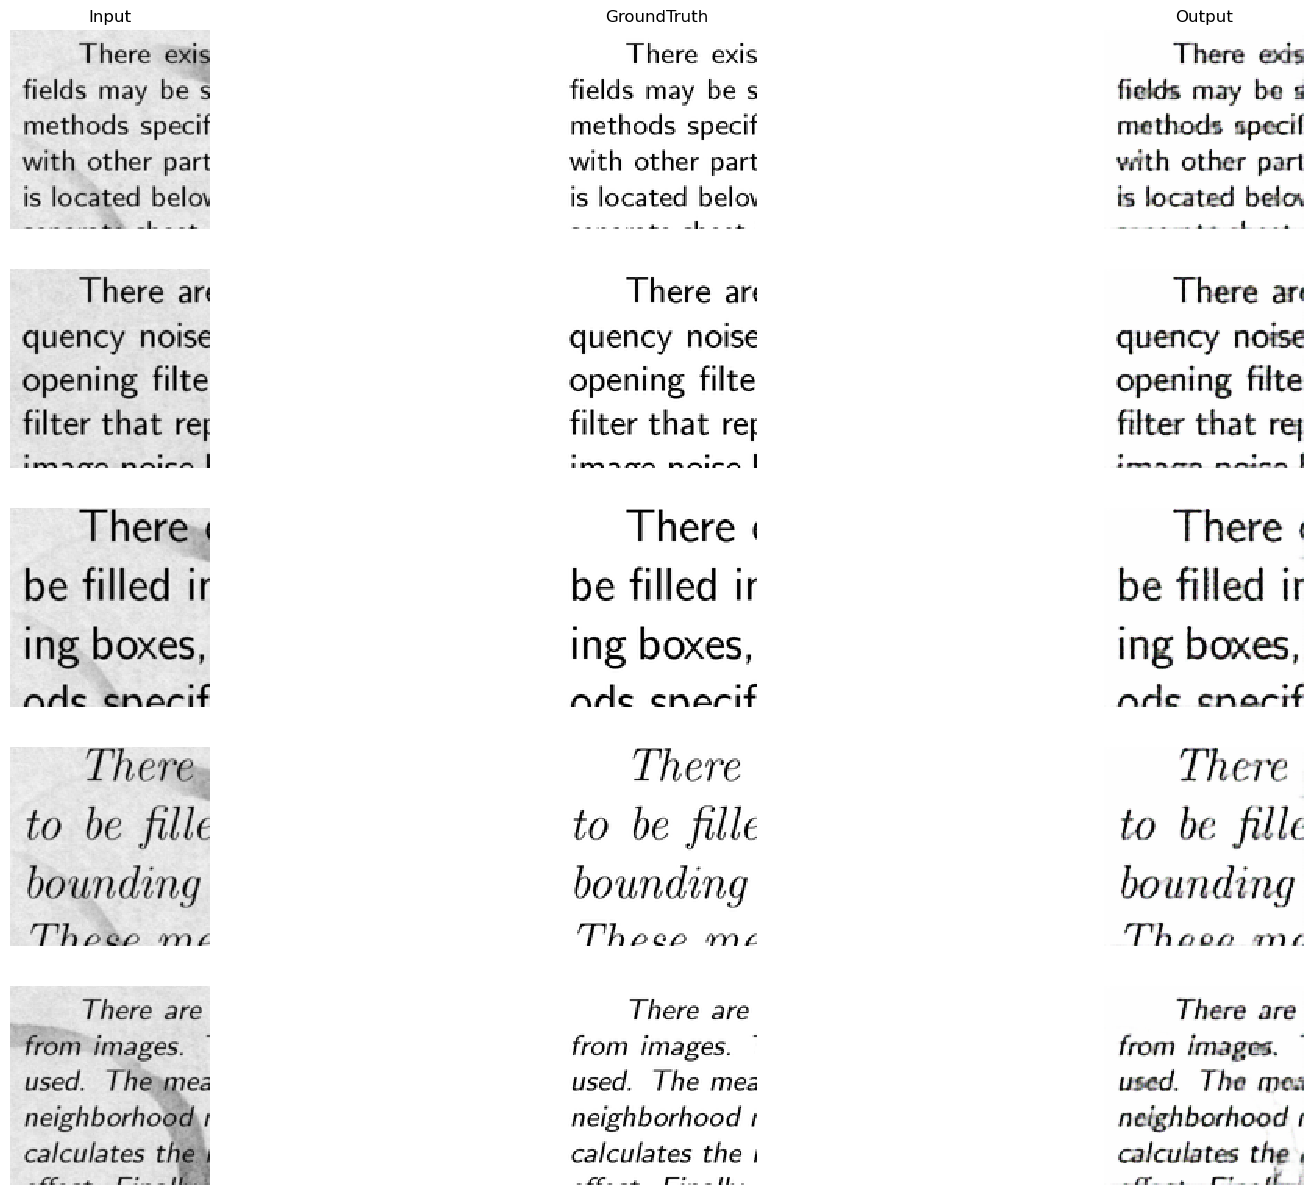

In [12]:
input_imgs, gt_imgs, output_imgs = [], [], []


denoiser.eval()
denoiser.to(device)

# model.eval()
# model.to(device)
dataset = DenoisingDB(input_imgs_path, cleaned_imgs_path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

with torch.no_grad():
  for idx, (input_img, gt_img) in enumerate(dataloader):
    if idx >= 5:
      break

    input_img, gt_img = input_img.to(device), gt_img.to(device)
    output_img = denoiser(input_img)
    # output_img = model(input_img)
    input_imgs.append(input_img[0].cpu().permute(1,2,0).numpy())
    gt_imgs.append(gt_img[0].cpu().permute(1,2,0).numpy())
    output_imgs.append(output_img[0].cpu().permute(1,2,0).numpy())


titles = ['Input', 'GroundTruth', 'Output']
plot_images_with_text([input_imgs, gt_imgs, output_imgs],titles,texts=None)
